Recrearemos los resultado del articulo de Gatys de Style-Transfer

# [Presiona aquí si deseas ir directo a la parte de la tarea](#tarea)

In [1]:
import random 
import gc

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage

import fastai.vision.all as fv
from fastai.callback.hook import hook_outputs

from fastprogress.fastprogress import progress_bar

#from Layers import num_params, Normalize

In [2]:
to_pil = ToPILImage()
to_tensor = ToTensor()

In [3]:
size = (384, 256)

# Contenido 

Primero haremos la aplicación más boba del mundo: A partir del ruido, crearemos la flor. Poco a poco iremos modificando el código para que al final lleguemos a transferencia de estilo. 

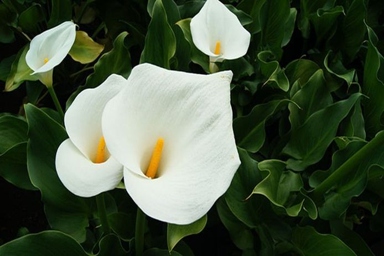

In [4]:
content_img = fv.PILImage.create("/notebooks/storage/flor.jpg").resize(size)
content_img

In [5]:
# Para tener idea de qué tan grande es nuestro modelo
def num_params(model):
    #total=0
    #for p in model.parameters():
        #num=1
        #for s in list(p.size()):
            #num *= s
        #total += num
        
    # Una manera de hacer más optimo lo anterior 
    total = sum([prod(p.shape) for p in model.parameters()])
    return (total)

In [6]:
class Normalize(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x-m)/s

In [7]:
content_tensor = Normalize()(to_tensor(content_img)[None])

In [8]:
content_tensor.shape

torch.Size([1, 3, 256, 384])

Dos funciones de ayuda: Una para desnormalizar y otra para ver: 

In [9]:
# Función para desnormalizar
def denorm(t):
    # Tomamos las stats de imagenet
    mean, sd = (torch.tensor(x) for x in fv.imagenet_stats)
    # Les ponemos las dimensiones apropiadas para 
    # hacer broadcasting
    mean, sd = mean[:, None, None],sd[:, None, None]
    # Si normalizar es: restar la media y dividir entre 
    # la desviación estandar, desnormalizar hace lo 
    # contrario
    return mean + t*sd

# Función para ir viendo nuestros resultados
def view(t):
    # Le quita los gradientes y la pasa a la cpu
    t = t.detach().cpu()
    # Si tiene la dimensión de uno, la aplasta
    # y la convierte a pil
    # torch.Size([Esta dimensión: -> 1, 3, 256, 384])
    if len(t.shape) == 4:
        t = t[0]
    
    # La convierte a pil después de desnormalizar
    # y poner todos los números entre 0 y 1
    return to_pil(denorm(t).clamp(0,1))

In [10]:
content_tensor.shape

torch.Size([1, 3, 256, 384])

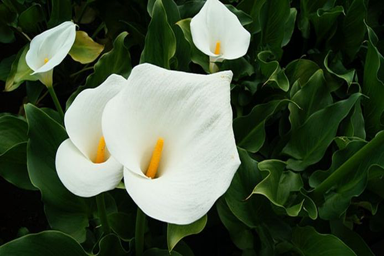

In [11]:
view(content_tensor)

In [12]:
content_tensor = content_tensor.cuda()

Vamos a crear ruidito aleatorio que iremos convirtiendo poco a poco a la imagen. **Notemos** que lo que estamos optimizando en si es los pixeles de la imagen *noise*, por eso le ponemos gradientes. 

In [13]:
noise = torch.randn_like(content_tensor, requires_grad = True)

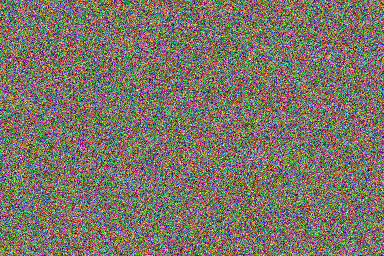

In [14]:
view(noise)

In [15]:
optimizer = torch.optim.Adam([noise], lr=1e-1)

In [16]:
pbar = progress_bar(range(1000))
for epoch in pbar:
    optimizer.zero_grad()
    
    # Por ahora, pensemos que la pérdida será la distancia
    # pixel a pixel a la original:
    loss = F.mse_loss(noise, content_tensor)
    # Basicamente lo que hicimos es que cada pixel de
    # nuestra imagen de ruido se pareciera a cada
    # pixel (a su respectivo pixel) de la imagen de 
    # la flor
    pbar.comment = f"loss = {loss.item()}"
    
    loss.backward()
    optimizer.step()

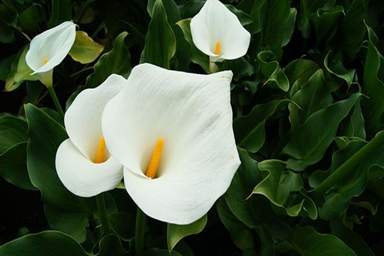

In [17]:
view(noise)

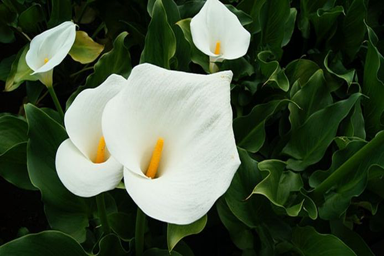

In [18]:
view(content_tensor)

Ahora procederemos a hacerlo de nuevo pero con algunos cambios: Ahora no vamos directamente a decirle que queremos que los pixeles en si se parezcan. Más bien vamos a decirle que queremos que las activaciones de una red neuronal pre-entrenada (en este caso usaremos VGG) se parezcan. 

A esta pérdida se le llama **Feature Loss** o **Perceptual Loss**

In [19]:
class PerceptualLoss(nn.Module):
    def __init__(self, model, layer_ids, weights=[1,3,8,12,20,10]):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach = False)
        self.weights = weights
        
    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone: 
            features = [f.clone() for f in features]
            
        return features
    
    def forward(self, x, content_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone=True)
        
        return sum([F.mse_loss(a,b)*w for a,b,w in zip(x_features, content_features, self.weights)])
    
    def __del__(self):
        self.hooks.remove() # Necesario para que deje de guardar las cosas

In [20]:
vgg = fv.vgg16_bn(pretrained=True)

In [21]:
#vgg

In [22]:
vgg = vgg.features

In [23]:
for p in vgg.parameters():
    p.requires_grad_(False) # p.requires_grad = False

In [24]:
good_blocks = [i for i,m in enumerate(vgg) if type(m) == nn.MaxPool2d]

In [25]:
good_blocks, len(vgg), content_tensor.shape

([6, 13, 23, 33, 43], 44, torch.Size([1, 3, 256, 384]))

In [26]:
perceptual_loss = PerceptualLoss(vgg, good_blocks).cuda()

In [27]:
noise = torch.randn_like(content_tensor, requires_grad=True)

In [28]:
optimizer = torch.optim.Adam([noise], lr=1e-1)

In [230]:
#pbar = progress_bar(range(2000))
pbar = progress_bar(range(1400))
for epoch in pbar:
    optimizer.zero_grad()
    
    # Por ahora, pensemos que la pérdida será la distancia
    # pixel a pixel a la original: 
    loss = perceptual_loss(noise, content_tensor)
    
    pbar.comment = f"loss = {loss.item():.3f}"
    
    loss.backward()
    optimizer.step()

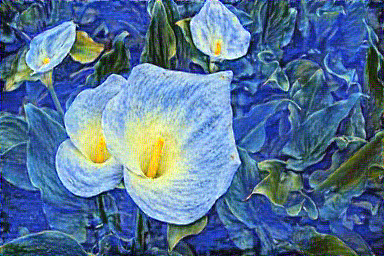

In [231]:
view(noise)

# ¡Agregando estilo!

In [31]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    
    # Por ahora, pensemos que la pérdida será la distancia
    # pixel a pixel a la original:
    # Optimzamos con mse para empezar con la imagen perfecta
    loss = F.mse_loss(noise, content_tensor)
    pbar.comment = f"loss = {loss.item()}"
    
    loss.backward()
    optimizer.step()

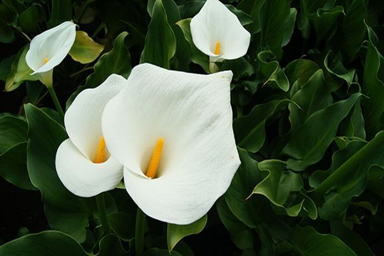

In [32]:
view(noise)

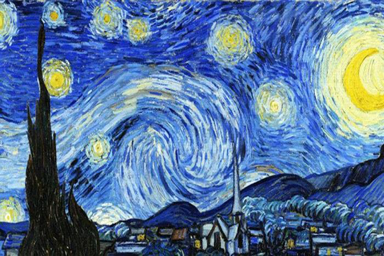

In [33]:
style = fv.PILImage.create("/notebooks/storage/nightS.jpg").resize(size)
style

In [34]:
style_tensor = Normalize()(to_tensor(style)).cuda()

In [35]:
#style_tensor

La idea genial de Gatys y ellos fue que podian entender el "estilo" como la *correlación* entre los diferentes canales de activaciones. 

Para calcular la correlación, simplemente hay que tomar el producto de matrices así (llamada la matriz de Gram):

In [173]:
def gram_matrix(x):
    bs,c,h,w = x.shape
    # Lo que nos pasen, lo aplanamos
    x = x.view(bs, c, h*w)
    # Prodcuo de matrices
    return (x @ x.transpose(1,2))/(c*h*w)


<a id="tarea"><h1><strong>La tarea empieza aquí</strong></h1></a>

In [223]:
class StyleAndContentLoss(nn.Module):  
    # Pasamos como parámetros la imagen de contenido y la imagen de estilo
    def __init__(self, content_image, style_image, model, layer_ids, content_weights=[1,3,8,12,20,10], style_weights=[20,25,15,10,4], style_mult=8e3):
        super().__init__()
        self.content_image = content_image
        self.style_image = style_image
        
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach=False)
        self.content_weights = content_weights
        self.style_weights = style_weights
        self.style_mult = style_mult
        
        
        #self.content_features = content_image
        # Extraemos sus caracteristicas tanto de la imagen de contenido 
        # como de la imagen de estilo
        self.content_features = self.extract_features(content_image, clone=True)
        self.style_features = self.extract_features(style_image, clone=True)
    
    
    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone: 
            features = [f.clone() for f in features]
            
        return features
     
        
    def content_loss(self, A, B):
        return sum([F.l1_loss(a,b)*w for a, b, w in zip(A, B, self.content_weights)])
    
    def style_loss(self, A, B):
        return sum([F.l1_loss(gram_matrix(a), gram_matrix(b))*w for a,b,w in zip(A,B,self.style_weights)])
    
    
    def forward(self, x):#, content_image, style_image):
        x_features = self.extract_features(x)
        #content_features = self.extract_features(content_image, clone=True)
        #style_features = self.extract_features(style_image, clone=True)
        
        # Accedemos a las variables con las caracteristicas de la imagen de contenido
        # de la imagen de estilo que ya fueron calculadas previamente
        self.CL = self.content_loss(x_features, self.content_features)
        self.SL = self.style_mult*self.style_loss(x_features, self.style_features)
        
        return self.CL + self.SL
        
        #return sum([F.mse_loss(a,b)*w for a,b,w in zip(x_features, content_features, self.weights)])
    
    def __del__(self):
        self.hooks.remove() # Necesario para que deje de guardar las cosas 

In [224]:
# Añadimos los parámetros de imagen de contenido y de estilo
def style_content_loss(content_img, style_img,**kwargs):
    vgg = fv.vgg16_bn(pretrained=True)
    vgg.eval()
    vgg = vgg.features
    for p in vgg.parameters(): p.requires_grad_(False)
    good_blocks = [i for i,o in enumerate(vgg.children()) if isinstance(o, nn.MaxPool2d)]
    
    #Pasamos a cuda el modelo y las imagenes para evitar errores
    vgg = vgg.cuda()
    content_img = content_img.cuda()
    style_img = style_img.cuda()
    #return(style_img)
    return StyleAndContentLoss(content_image = content_img, style_image = style_img, model=vgg, layer_ids=good_blocks, **kwargs)

In [225]:
content_and_style_loss = style_content_loss(content_tensor, style_tensor).cuda()
#view(content_and_style_loss)

In [226]:
optimizer = torch.optim.Adam([noise], lr=1e-1)

In [229]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    
    # Dado que a la hora de crear "content_and_style_loss" las imagenes ya fueron pasadas
    # ya no es necesario volverlas a pasar
    loss = content_and_style_loss(noise)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.2f} | style_loss = {content_and_style_loss.SL:.2f} | total_loss = {loss.item():.2f}"
    
    loss.backward()
    optimizer.step()

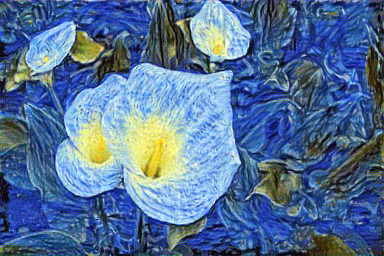

In [44]:
view(noise)